<a href="https://colab.research.google.com/github/bosecodes/slytherin-slingshot/blob/master/Transfer_Learning_Finding_Dog_Breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Transferred MobileNet (based on ImageNet) to create a Dog Breed Classifier

We try to create a simple neural network that can classify and recognize different dog breeds. For keeping the example simple, we'll oly use a handfull of breeds. A much more advanced version of the model can be found at Microsoft Dog Breed Image Search.

To keep computations to a bare minimum, we use MobileNet, which is built into Keras. Here are the steps we follow:
- We load the entire MobileNet and see how well it can classify several test images. MobileNet can classify 1000 different images. - We will ultimately extend it to classify images that are not in the dataset, in this example, 3 dog breeds.
- However we begin by classifying image types among those that it were trained on. Even though our test images were not in its training set, the loaded neural network should be able to classify them.


In [0]:
# Import all essential libraries

import pandas as pd
import numpy as np
import os
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

We begin by downloading weights for a MobileNet trained on the imagenet dataset.

In [2]:
model = MobileNet(weights = 'imagenet', include_top = True)

17227776/17225924 [==============================] - 1s 0us/step


The loaded network is a Keras neural netowrk, just like those that we've been working on so far. However, this is a neural network that was trained on advanced hardware. Simply looking at the structure of an advanced State-of-the-art neural network is really intersesting!

In [3]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

By examining the above structure, we find out several features about the neural network architecture.

- Some layers have zeroes in the number of parameters. Items which are hyperparameters are always zero, nothing about that layer is ever learned. The other layers have learnable parameters that are adjusted as training occurs. The layer types are trained/adjusted by the training algorithm. Most of the parameters seen above are the weights of the neural network.

- Some of the parameters are marked as non-trainable. These can't be adjusted by the learning algorithm. When we'll use transfer learning with this model we will strip off the final layers that classify 1000 items and replace them with the 3 dog breeds that we wish to classify. **Then, only our new layers will be trainable, the other existing layers will be non-trainable.**

- The Relu activation function is used throughout the network. Also batch and dropout normalization is used. The percentage of batch normalization can be found in the original paper. Many deep neural nets are pyramid shaped, and this is the case for this one as well. We can see the expanding pyramid shape as the neuron/filter counts expand from 32 to 64 to 128 to 256 to 512 to topping out at 1024.


_We now use the MobileNet to classify several image url's below. Feel free to test out your own images._


'__________________________________________________________________'

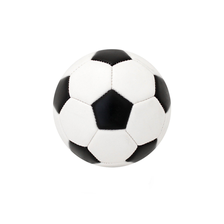

[805]
40960/35363 [==================================] - 0s 0us/step
('n04254680', 'soccer_ball', 0.9999938)
('n03530642', 'honeycomb', 3.8624116e-06)
('n03255030', 'dumbbell', 4.442458e-07)
('n02782093', 'balloon', 3.7038987e-07)
('n04548280', 'wall_clock', 3.143911e-07)


'__________________________________________________________________'

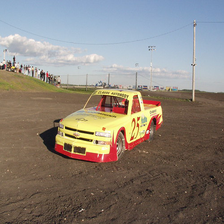

[751]
('n04037443', 'racer', 0.7131951)
('n03100240', 'convertible', 0.100896776)
('n04285008', 'sports_car', 0.0770768)
('n03930630', 'pickup', 0.026353048)
('n02704792', 'amphibian', 0.011636168)


'__________________________________________________________________'

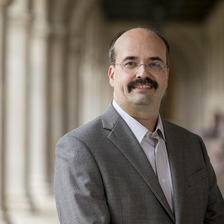

[834]
('n04350905', 'suit', 0.98860943)
('n04591157', 'Windsor_tie', 0.004567416)
('n10148035', 'groom', 0.0029069302)
('n04479046', 'trench_coat', 0.0013268597)
('n02992529', 'cellular_telephone', 0.00035402415)


'__________________________________________________________________'

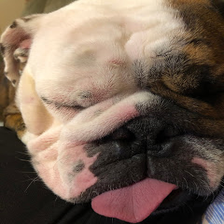

[254]
('n02110958', 'pug', 0.495279)
('n02108915', 'French_bulldog', 0.39188728)
('n02108089', 'boxer', 0.05534864)
('n02108422', 'bull_mastiff', 0.021636527)
('n02112706', 'Brabancon_griffon', 0.016767107)


In [4]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

images = [
    "https://cdn.shopify.com/s/files/1/0712/4751/products/SMA-01_2000x.jpg?v=1537468751",
    "https://farm2.static.flickr.com/1394/967537586_87b1358ad3.jpg",
    "https://sites.wustl.edu/jeffheaton/files/2016/07/jheaton_wustl1-262izm5-458x458.jpg",
    "https://1.bp.blogspot.com/-0vGbvWUrSAA/XP-OurPTA4I/AAAAAAAAgtg/TGx6YiGBEGIMjnViDjvVnYzYp__DJ6I-gCLcBGAs/s320/B%252Bt%2525aMbJQkm3Z50rqput%252BA.jpg" 
]

def make_square(img):
  cols, rows = img.size

  if rows > cols:
    pad = (rows-cols) / 2
    img = img.crop((pad,0, cols, cols))
  else:
    pad = (cols - rows) / 2
    img = img.crop((0, pad, rows, rows))

  return img

for url in images:
  x = []
  ImageFile.LOAD_TRUNCATED_IMAGES = False
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()
  img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  pred = model.predict(x)

  display("__________________________________________________________________")
  display(img)
  print(np.argmax(pred, axis = 1))
  
  lst = decode_predictions(pred, top = 5)
  for itm in lst[0]:
    print(itm)

Overall, we can see that the neural network is doing quite well. It cannot classify the second image as a 'person' but as a 'suit'. Also the third image is of an English Bulldog, and not a Pug or a French Bulldog. This is likely because the image is really a close-up.

For many applications, if you need to classify very common images, MobileNet can be entirely acceptable as an image classifier. However, if we need to classify some very specialized images taht are not in the 1000 image types supported by the ImageNet (classes labelled from 0 to 999), we necessarily use Transfer Learning.

# Transfer Learning

We can create our own custom image classification network from scratch. However, this would take a lot of time and resources on a computational level. Just creating a dog breed classifier would require a large number of images of dogs, labelled by breed. However, if we use a pretrained neural network, we are tapping into knowledge that is already built onto the lower layers of the neural net. The transferred layers likely already have some notion of eyes, ears, feet and fur. These lower level concepts help to trian the neural network to identify the dog breeds.

Next we reload the MobileNet, this time, we set the include_top parameter to False. This instructs Keras to not load the final 1000 classification layer. This is the common mode of Transfer Learning. We display the summary to see that the top classification layer is therefore missing!

In [5]:
base_model = MobileNet(weights = 'imagenet', include_top = False)

base_model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________

We will now add new top layers to the neural network. Our final SoftMax layer will include support for 3 classes.

In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
preds = Dense(3, activation = 'softmax')(x)

Next, we mark the original MobileNet layers as non-trainable and our new layers as trainable

In [0]:
model = Model(inputs = base_model.input, outputs = preds)

for layer in model.layers[:20]:
  layer.trainable = False
for layer in model.layers[20:]:
  layer.trainable = True

To train the neural network we must create a directory structure to hold the images. **The Keras command flow_from_directory performs this for us. It requires that a folder be laid out.**

image

Each class is a folder that contains images of that class. We can also specify a target size, in this case the original MobileNet size of 224x224 is desired.

In [13]:
!unzip dogs.zip

Archive:  dogs.zip
   creating: dogs/
   creating: dogs/class1/
  inflating: dogs/class1/maxresdefault.jpg  
  inflating: dogs/class1/english-bulldog-card-small.jpg  
  inflating: dogs/class1/264b91e3882084aa3747199833af53a7.jpg  
  inflating: dogs/class1/bulldog.jpg  
  inflating: dogs/class1/ZsaZsaUglyDogContest.jpg  
   creating: dogs/class2/
  inflating: dogs/class2/Pug-On-White-01.jpg  
  inflating: dogs/class2/Mops_oct09_cropped2.jpg  
  inflating: dogs/class2/download.jpeg  
  inflating: dogs/class2/images.jpeg  
  inflating: dogs/class2/istock-1128787444.jpg  
   creating: dogs/class3/
  inflating: dogs/class3/1._DSC_0346_(10096362833).jpg  
  inflating: dogs/class3/german-shepherd-dog-15.jpg  
  inflating: dogs/class3/German-Shepherd-on-White-00.jpg  
  inflating: dogs/class3/Correct-Type-Best-in-Show-Westminster-2017-RUMOR.jpg  
  inflating: dogs/class3/download.jpeg  


In [14]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator = train_datagen.flow_from_directory('dogs', 
                                                    target_size= (224, 224),
                                                    color_mode = 'rgb',
                                                    batch_size = 1, 
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 15 images belonging to 3 classes.


Let's now compile and fit the neural network. Notice we are using **fit_generator instead of fit**, this is because we are using the convenient **ImageDataGenerator**.


In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size
model.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = 50)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
15/15 [==============================] - 0s 23ms/step - loss: 3.0744 - accuracy: 0.3333
Epoch 2/50
15/15 [==============================] - 0s 22ms/step - loss: 1.3832 - accuracy: 0.2667
Epoch 3/50
15/15 [==============================] - 0s 22ms/step - loss: 1.3352 - accuracy: 0.2667
Epoch 4/50
15/15 [==============================] - 0s 21ms/step - loss: 0.9554 - accuracy: 0.6000
Epoch 5/50
15/15 [==============================] - 0s 20ms/step - loss: 0.5601 - accuracy: 0.8000
Epoch 6/50
15/15 [==============================] - 0s 22ms/step - loss: 0.2129 - accuracy: 0.9333
Epoch 7/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0626 - accuracy: 1.0000
Epoch 8/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6378 - accuracy: 0.8000
Epoch 9/50
15/15 [==============================] - 0s 22ms/step - loss: 0.2997 - accuracy: 0.8667
Epoch 10/50
15/15 [==============

Let's check how we perform using our model now!

'___________________________________________________________________________________________'

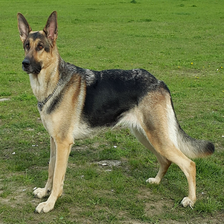

[2]


'___________________________________________________________________________________________'

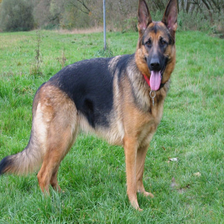

[2]


'___________________________________________________________________________________________'

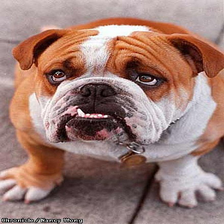

[1]


'___________________________________________________________________________________________'

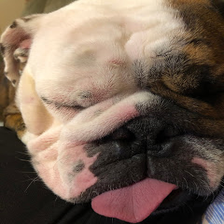

[1]


'___________________________________________________________________________________________'

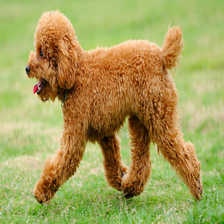

[1]


'___________________________________________________________________________________________'

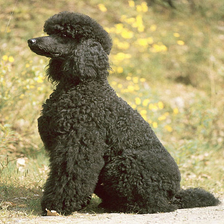

[1]


In [16]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

images = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/02.Owczarek_niemiecki_u%C5%BCytkowy_kr%C3%B3tkow%C5%82osy_suka.jpg/2560px-02.Owczarek_niemiecki_u%C5%BCytkowy_kr%C3%B3tkow%C5%82osy_suka.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/5/51/DSHwiki.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Axel%2C_the_English_Bulldog.jpg/440px-Axel%2C_the_English_Bulldog.jpg",
    "https://1.bp.blogspot.com/-0vGbvWUrSAA/XP-OurPTA4I/AAAAAAAAgtg/TGx6YiGBEGIMjnViDjvVnYzYp__DJ6I-gCLcBGAs/s320/B%252Bt%2525aMbJQkm3Z50rqput%252BA.jpg",
    "https://thehappypuppysite.com/wp-content/uploads/2017/12/poodle1.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Pudel_Grossschwarz.jpg/440px-Pudel_Grossschwarz.jpg"
    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
        
for url in images:
    x = []
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT),Image.ANTIALIAS)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    
    display("___________________________________________________________________________________________")
    display(img)
    print(np.argmax(pred,axis=1))